# PI-CAI dataset exploration

In [1]:
import os
from os.path import join
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import SimpleITK as sitk


from exploratoryAnalysis.DataAnalyzer import DataAnalyzer
from time import perf_counter

DATA_ROOT = "/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai"

paths = {
    "picai_labels_wg" : "picai_labels-main/anatomical_delineations/whole_gland/AI/Guerbet23",
    "picai_labels_zonal" : "picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23",
    "picai_folds" : "picai_folds/picai_images_fold0"
}

analyzer = DataAnalyzer(DATA_ROOT)


> Every patient case will at least have three imaging sequences: axial T2W, axial DWI and axial ADC scans (i.e. files ending in _t2w.mha, _hbv.mha, _adc.mha). Additionally, they can also have either, both or none of these optional imaging sequences: sagittal and coronal T2W scans (i.e. files ending in _sag.mha, _cor.mha here). 

We see some patitent cases that have additional images (more than one study was performed on them).

In [2]:
pth = os.path.join(paths["picai_folds"])
folds = analyzer.get_dirs(pth)

for fold in folds:
    rel = os.path.join(pth, fold)
    dirs = analyzer.get_dirs(rel)
    incomplete_dirs = []
    total = 0

    for dir in dirs:
        # check if they all have 5 files
        rel2 = os.path.join(rel, dir)
        
        files = analyzer.get_files(rel2)

        if len(list(files)) != 5:
            print(f"Directory {dir} has {
                # do this because the analyzer returns a generator
                len(list(analyzer.get_files(rel2)))} files, expected 5.")
            incomplete_dirs.append(dir)
        total += 1

    print(f"Number of non-matching directories: {len(incomplete_dirs)}")

    print("Total file count excluding the previous non-matching: ", (total - len(incomplete_dirs) ) * 5)



Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file count excluding the previous non-matching:  0
Number of non-matching directories: 0
Total file c

Now, we plot some of the images. We also need to see how each zone is labeled. (pz=1 or 2, tz=1 or 2, etc.)

**As we see, the TZ is labeled as 1 and the PZ as 2.**

Image 1: /media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_folds/picai_images_fold0/10000/10000_1000000_t2w.mha
Image 1 size: (640, 640, 31), spacing: (0.28125, 0.28125, 3.2999999825580133)
Image 2 size: (640, 640, 31), spacing: (0.28125, 0.28125, 3.299999952316284)
Image 3 size: (640, 640, 31), spacing: (0.28125, 0.28125, 3.299999952316284)


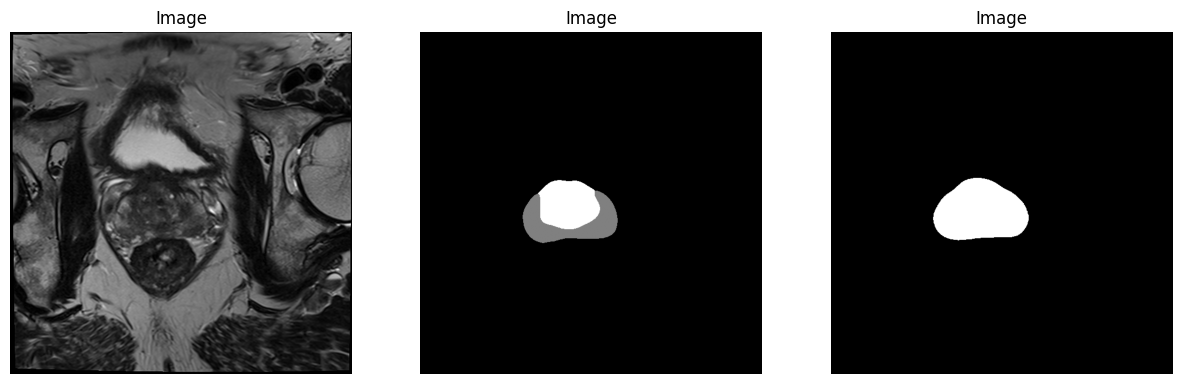

In [3]:

# pick a random folder and set the name of a file inside as the prefix
dirs = list(analyzer.get_dirs(paths["picai_folds"]))
random_dir = "10000"# random.choice(dirs)
files_in_dir = analyzer.get_files(join(paths["picai_folds"], random_dir), ".*_t2w.mha$")

# we have to do this because get files is a generator
name = next(files_in_dir)
i1 = join(paths["picai_folds"], random_dir, name)

# get the corresponding nii.gz file that masks the image
nii = name.split("_t2w")[0].split("/")[-1] + ".nii.gz"
i2 = join(paths['picai_labels_zonal'], nii)

# get the whole gland mask
i3 = join(paths['picai_labels_wg'], nii)

# read the images
i1, i2, i3 = sitk.ReadImage(join(DATA_ROOT, i1)), \
    sitk.ReadImage(join(DATA_ROOT, i2)), \
    sitk.ReadImage(join(DATA_ROOT, i3))

# print the size and spacing of the images
print(f"Image 1: {join(paths["picai_folds"], random_dir, name)}")
print(f"Image 1 size: {i1.GetSize()}, spacing: {i1.GetSpacing()}")
print(f"Image 2 size: {i2.GetSize()}, spacing: {i2.GetSpacing()}")
print(f"Image 3 size: {i3.GetSize()}, spacing: {i3.GetSpacing()}")

analyzer.show_image(i1, i2, i3, save="/home/guest/code")

Let's look for possible empty masks, since some of the lesion data was missing

In [4]:
analyzer.regex = r".*mha$"
non_empty_count, empty_masks = analyzer.count_and_find_non_empty_masks(paths['picai_labels_zonal'])
print(f"{non_empty_count} out of {non_empty_count+len(empty_masks)} masks are non-empty (contain a segmentation).")
print("Empty mask files:", empty_masks)

0 out of 0 masks are non-empty (contain a segmentation).
Empty mask files: []


Is the whole gland the sum of the zonal masks?

A we see th ewhole gland is sligtly bigger in most cases, indicating it's not just the sum. 
This might be due to differences in the model used for automatic labeling.

As mentioned in the PICAI dataset, the anatomical anottations are made automatically, and furthermore they use different algorithms for whole gland and zonal segmentation.
Therefore, there might be some differences in the whole gland and zonal masks. 

/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10836_1000852.nii.gz
/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10913_1000930.nii.gz
/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10466_1000474.nii.gz
/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11144_1001167.nii.gz
/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10834_1000850.nii.gz
/media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10751_1000767.nii.gz


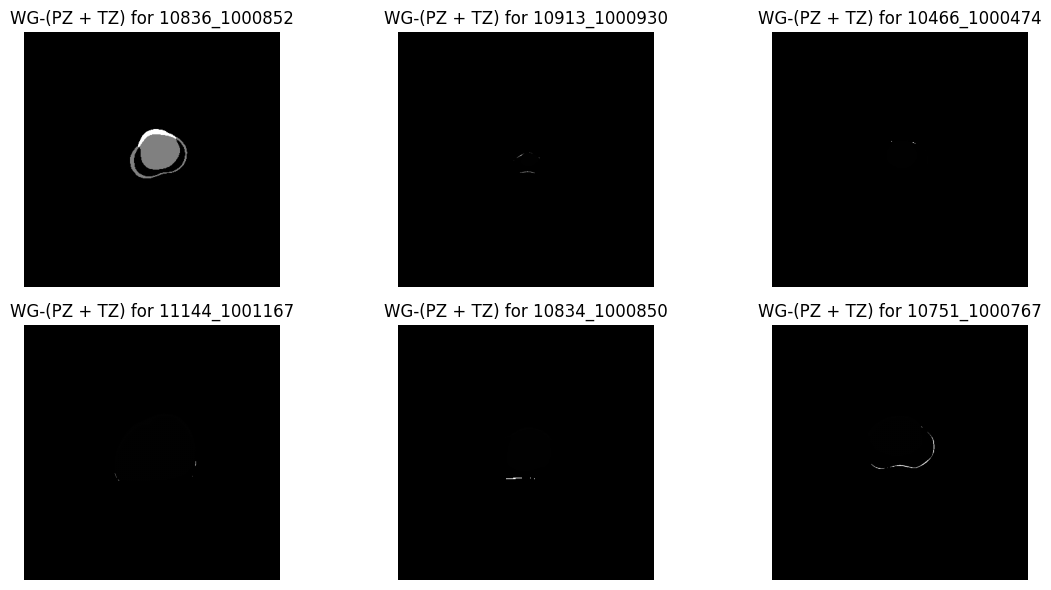

In [5]:

# pick a random folder and set the name of a file inside as the prefix
d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=6)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Create a 3x2 figure with axes
axes = axes.flatten()  # Flatten the axes array for easier indexing

for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), ".*_t2w.mha$")

    # We have to do this because get_files is a generator
    name = next(files_in_dir)

    # Get the corresponding nii.gz file that masks the image
    nii = os.path.basename(name).split("_t2w")[0] + ".nii.gz"
    i2 = join(DATA_ROOT, paths['picai_labels_zonal'], nii)
    print(i2)


    # Get the whole gland mask
    i3 = join(DATA_ROOT, paths['picai_labels_wg'], nii)

    # Turn the images into arrays, set all labels >= 1 to 1
    # Then, do the difference between both and display it to see where they differ
    i2 = sitk.ReadImage(i2)
    image_array = sitk.GetArrayViewFromImage(i2)
    image_array[image_array >= 1]
    #print(image_array[image_array.shape[0] // 2, :, :])

    i3 = sitk.ReadImage(i3)
    i3_array = sitk.GetArrayViewFromImage(i3)
    i3_array[i3_array >= 1]
    #print(i3_array[i3_array.shape[0] // 2, :, :])

    diff = (image_array - i3_array)
    diff[diff >= 1] # Keep only positive differences
    diff = diff[image_array.shape[0] // 2, :, :] # take the middle slice by default
    
    # Plot the image diff on the corresponding axis
    axes[idx].imshow(diff, cmap='gray')
    axes[idx].set_title(f"WG-(PZ + TZ) for {os.path.basename(name).split('_t2w')[0]}")
    axes[idx].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#analyzer.show_image(i2, i3, save="../combined_images.png")

Now, we use the function the analyzer to analyze the metadata.

In [6]:
# use this regex to filter the files
analyzer.regex = "(.*_t2w.mha$)|(.*_sag.mha$)|(.*_cor.mha$)"
res = analyzer.collect_metadata_to_dataframe("picai_folds/picai_images_fold0/10189")
print(res)

df = []
start = perf_counter()
for i in range(5):
    df.append(analyzer.collect_metadata_from_subdirs(f"picai_folds/picai_images_fold{i}"))
# join the dataframes
df = pd.concat(df, ignore_index=True)
print(perf_counter() - start, "seconds")
df

                filename        dim_size              spacing orientation  \
0  10189_1000192_sag.mha  (320, 320, 21)  (0.562, 0.562, 3.6)         ASL   
1  10189_1000192_cor.mha  (320, 320, 19)      (0.6, 0.6, 3.6)         RSA   
2  10189_1000192_t2w.mha  (640, 640, 21)      (0.3, 0.3, 3.6)         RAI   

   prostate_volume   vendor    mri_name  psa_report  
0            125.0  SIEMENS  Prisma_fit        5.97  
1            125.0  SIEMENS  Prisma_fit        5.97  
2            125.0  SIEMENS  Prisma_fit        5.97  
68.558646569 seconds


,filename,dim_size,spacing,orientation,prostate_volume,vendor,mri_name,psa_report
0,10000_1000000_t2w.mha,"(640, 640, 31)","(0.281, 0.281, 3.3)",RAI,55.0,SIEMENS,Skyra,7.7
1,10000_1000000_cor.mha,"(640, 640, 23)","(0.312, 0.312, 3.3)",RSA,55.0,SIEMENS,Skyra,7.7
2,10000_1000000_sag.mha,"(640, 640, 29)","(0.312, 0.312, 3.3)",ASL,55.0,SIEMENS,Skyra,7.7
3,10001_1000001_sag.mha,"(320, 320, 19)","(0.562, 0.562, 3.6)",ASL,102.0,SIEMENS,Skyra,8.7
4,10001_1000001_cor.mha,"(320, 320, 19)","(0.6, 0.6, 3.6)",RSA,102.0,SIEMENS,Skyra,8.7
...,...,...,...,...,...,...,...,...
4490,11470_1001494_sag.mha,"(320, 320, 20)","(0.562, 0.562, 4.0)",ASL,47.0,Philips Medical Systems,Achieva,9.1
4491,11470_1001494_cor.mha,"(384, 384, 25)","(0.469, 0.469, 3.0)",RSA,47.0,Philips Medical Systems,Achieva,9.1
4492,11475_1001499_sag.mha,"(320, 320, 19)","(0.562, 0.562, 3.0)",ASL,33.0,SIEMENS,TrioTim,15.0
4493,11475_1001499_cor.mha,"(320, 320, 15)","(0.562, 0.562, 3.0)",RSA,33.0,SIEMENS,TrioTim,15.0


Unique vendors: ['SIEMENS' 'Philips Medical Systems' 'Philips Healthcare']


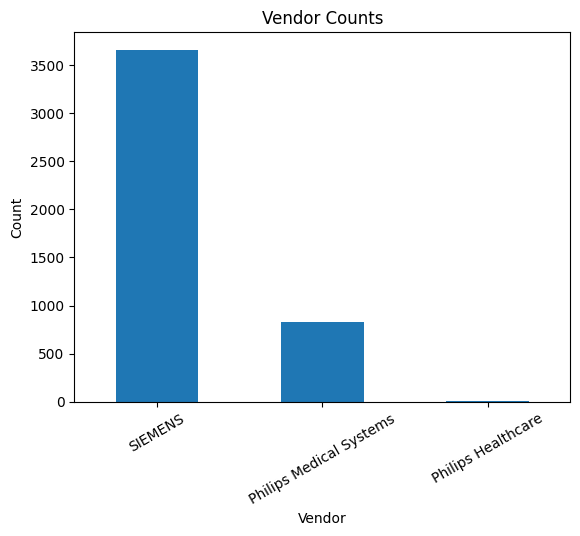

In [7]:
# checking unique vendors and count
vendors = df['vendor'].unique()
print("Unique vendors:", vendors)
# Count occurrences of each vendor
vendor_counts = df['vendor'].value_counts()
# plot them
vendor_counts.plot(kind='bar', title='Vendor Counts')
plt.xlabel('Vendor')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

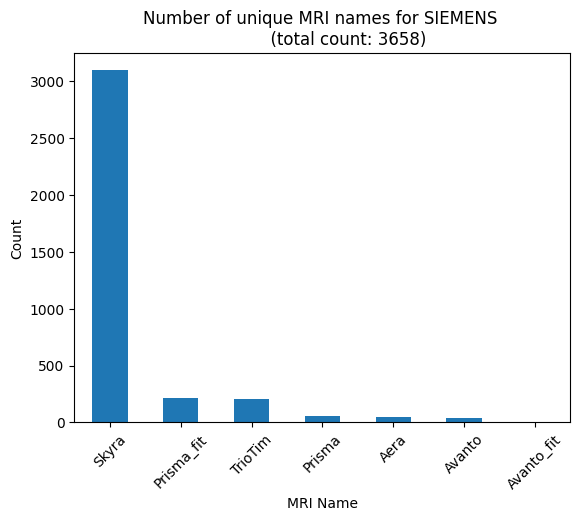

In [8]:
# for all the rows with vendor SIEMENS, get number of unique mri_names
siemens_mri_names = df[df['vendor'] == 'SIEMENS']['mri_name'].value_counts()

import matplotlib.pyplot as plt
siemens_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for SIEMENS 
          (total count: {})""".format(siemens_mri_names.sum()))
plt.xticks(rotation=45)
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

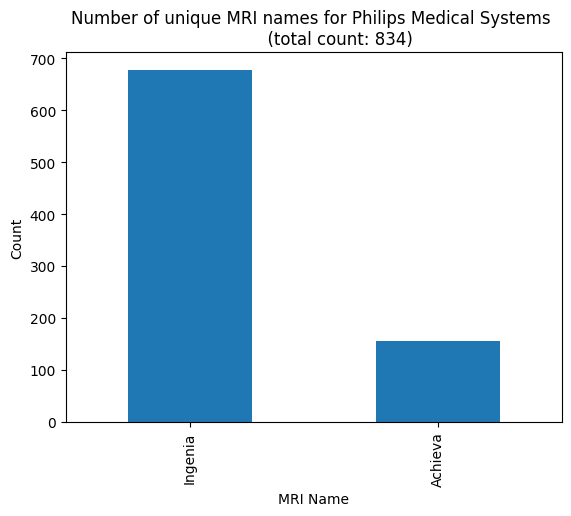

In [9]:
# for all the rows with vendor Philips Medical Systems, get number of unique mri_names
phl_mri_names = df[df['vendor'] == 'Philips Medical Systems']['mri_name'].value_counts()

# plot in a bar graph
import matplotlib.pyplot as plt
phl_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for Philips Medical Systems 
          (total count: {})""".format(phl_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

Now, we are interested in the dimensons and resolutions of the data, and how they are distrubuted trough the dataset.

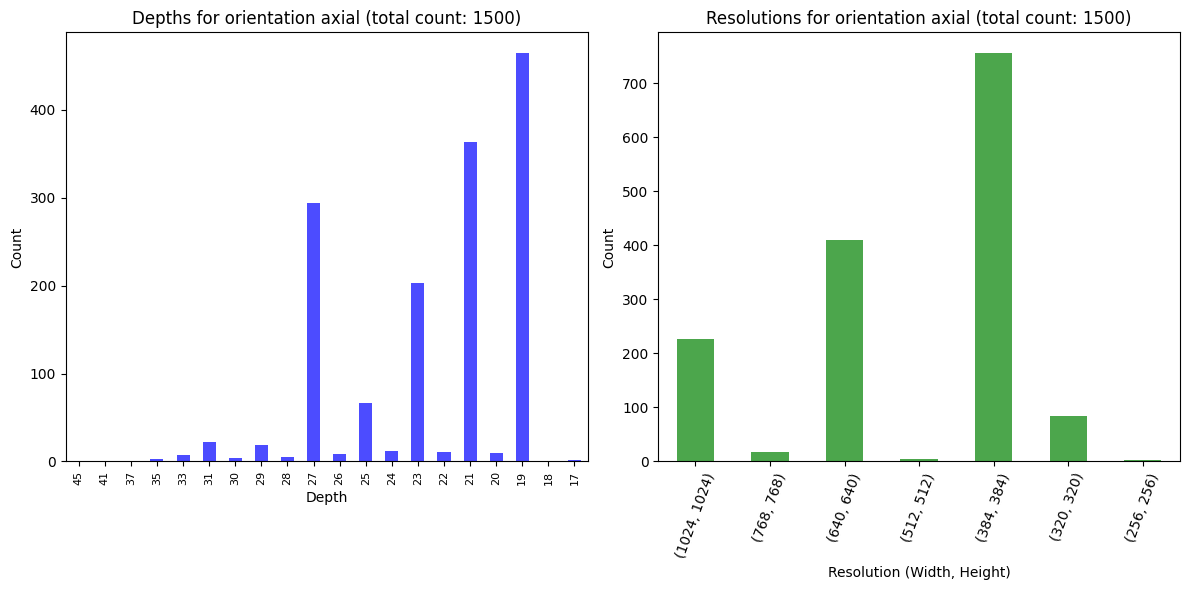

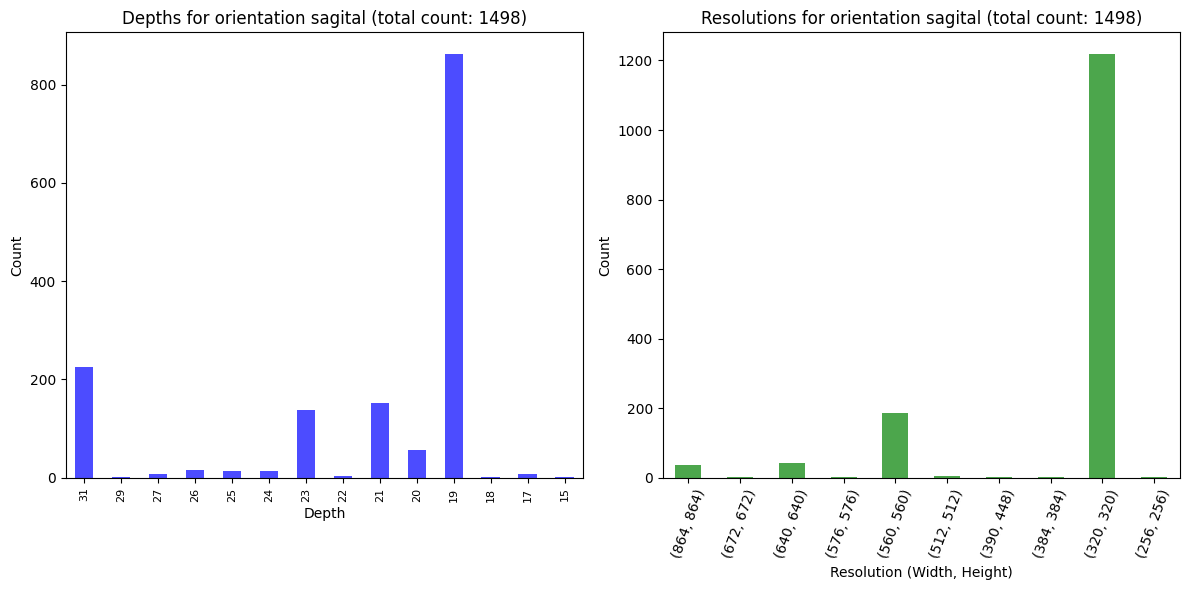

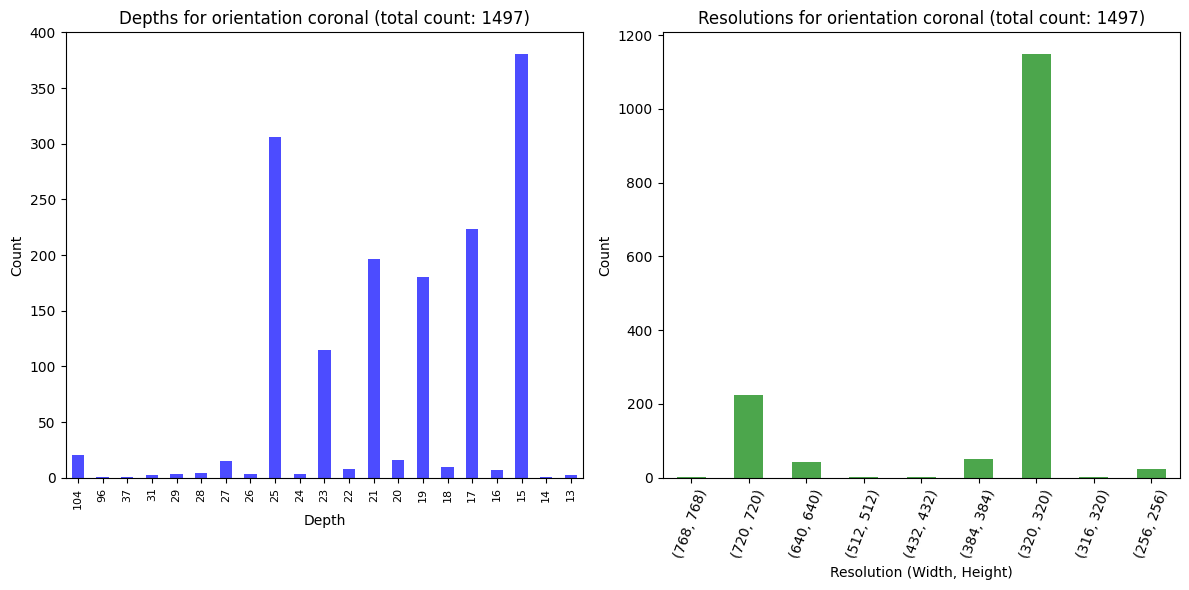

In [10]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    
    # Obtener el conteo de dim_size y ordenarlo
    #dim_sizes = orientation_df['dim_size'].value_counts().sort_index(ascending=False)
    
    # Agrupar por resolución (ancho, alto) ignorando la profundidad
    resolution_counts = (
        orientation_df['dim_size']
        .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
        .value_counts()
        .sort_index(ascending=False)
    )

    depth_counts = orientation_df['dim_size'].apply(lambda x: x[2]).value_counts().sort_index(ascending=False)
    
    # Crear dos gráficos separados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Dos gráficos lado a lado

    # Primer gráfico: depth
    depth_counts.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    ax1.set_title(f"Depths for orientation {value} (total count: {depth_counts.sum()})")
    ax1.set_xlabel("Depth")
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=90, labelsize=8)

    # Segundo gráfico: resolución (ancho, alto)
    resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
    ax2.set_title(f"Resolutions for orientation {value} (total count: {resolution_counts.sum()})")
    ax2.set_xlabel("Resolution (Width, Height)")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=70)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

We will do a similar thing as the previous step, but now we will use the spacing data to see the voxel size of the images.

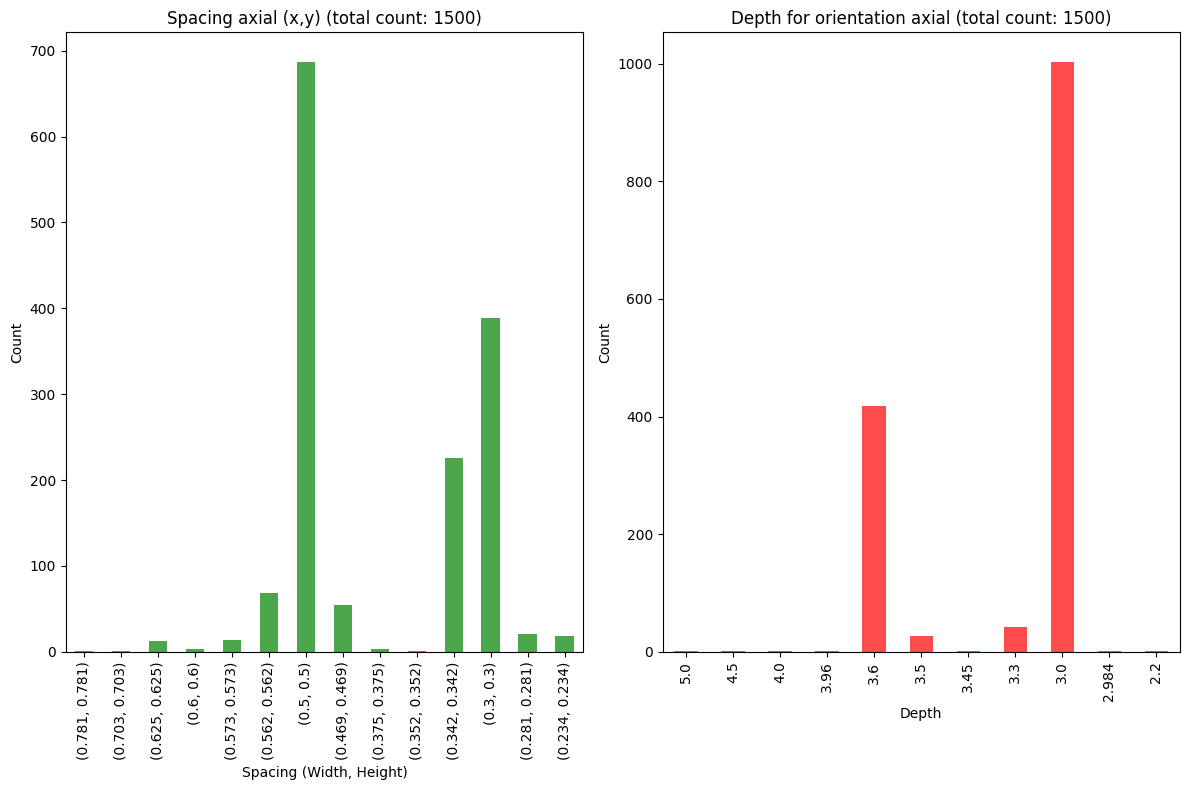

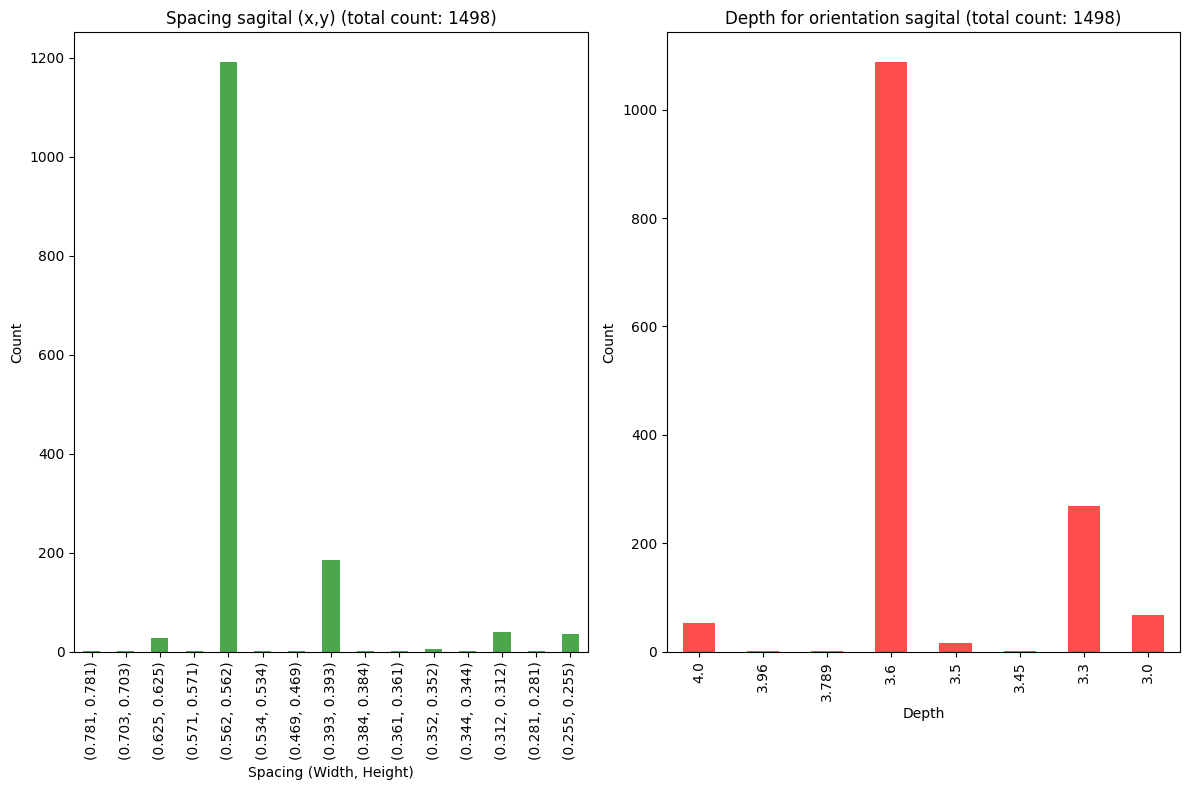

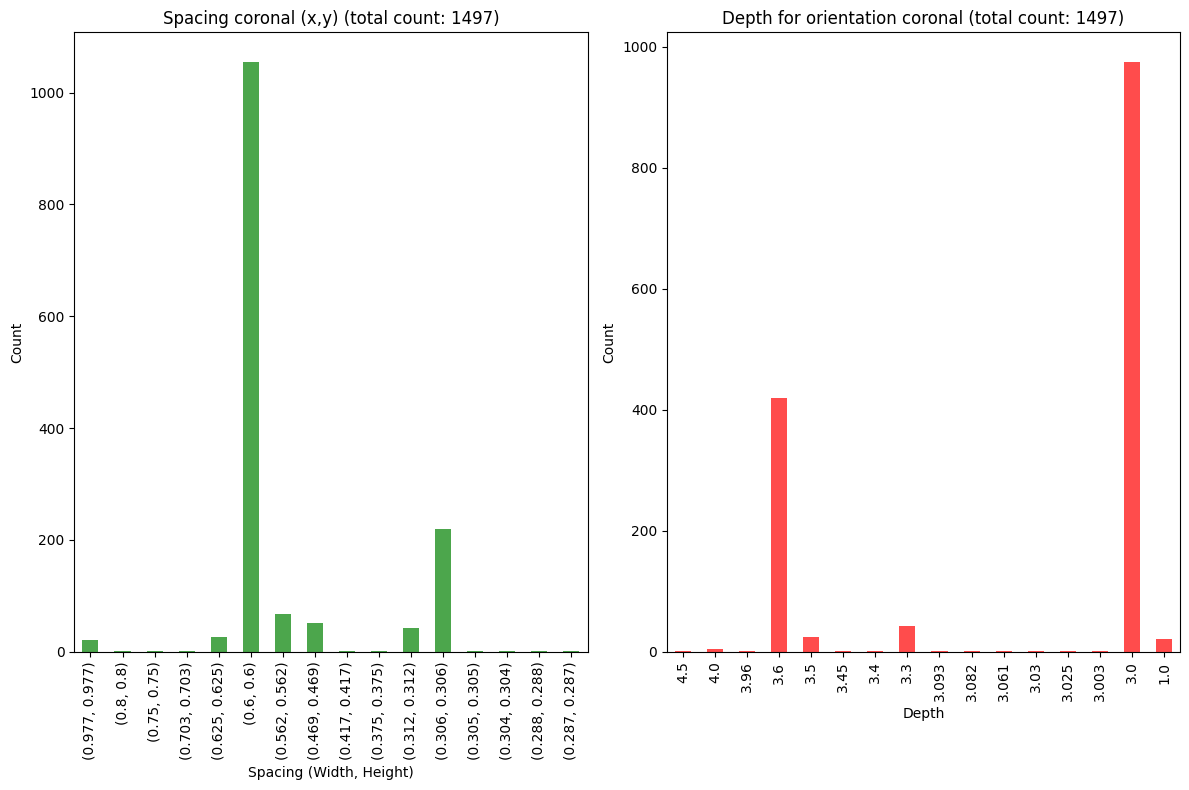

In [11]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    
    dim_sizes = orientation_df['spacing'].value_counts().sort_index(ascending=False)
    
    # Agrupar por resolución (ancho, alto) ignorando la profundidad
    resolution_counts = (
        orientation_df['spacing']
        .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
        .value_counts()
        .sort_index(ascending=False)
    )

    # agrupar por la profundidad de la imagen
    depth_counts = (
        orientation_df['spacing']
        .apply(lambda x: (x[2]))  # Extraer solo la profundidad
        .value_counts()
        .sort_index(ascending=False)
    )
    
    
    # Crear dos gráficos separados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))  # Dos gráficos lado a lado

    # # Primer gráfico: dim_size
    # dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    # ax1.set_title(f"Spacing {value} (total count: {dim_sizes.sum()})")
    # ax1.set_xlabel("Spacing")
    # ax1.set_ylabel("Count")
    # ax1.tick_params(axis='x', rotation=90, labelsize=8)

    # Segundo gráfico: resolución (ancho, alto)
    resolution_counts.plot(kind='bar', ax=ax1, color='green', alpha=0.7)
    ax1.set_title(f"Spacing {value} (x,y) (total count: {resolution_counts.sum()})")
    ax1.set_xlabel("Spacing (Width, Height)")
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=90)

    # Tercer gráfico: profundidad
    depth_counts.plot(kind='bar', ax=ax2, color='red', alpha=0.7)
    ax2.set_title(f"Depth for orientation {value} (total count: {depth_counts.sum()})")
    ax2.set_xlabel("Depth")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=90)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

We must also check the image pixel intensities for normalization.

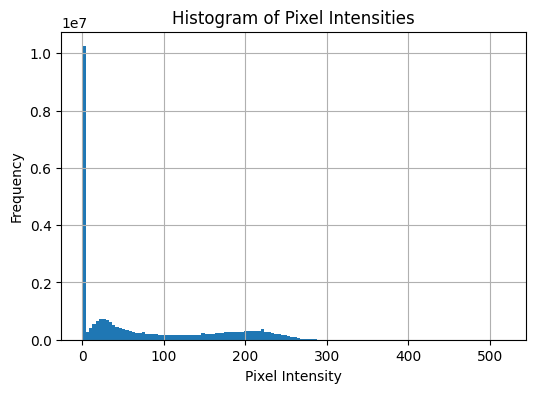

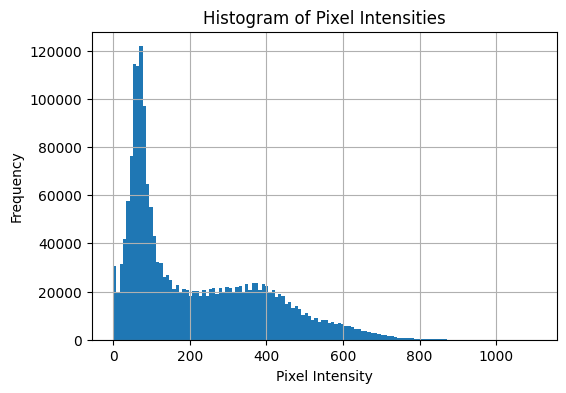

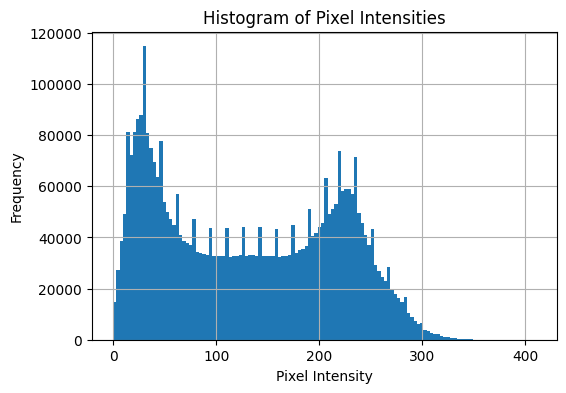

In [12]:
# plot pixel intensity histograms for a random selection of images

d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=3)


for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), ".*_t2w.mha$")

    # We have to do this because get_files is a generator
    name = list(files_in_dir)[0]
    i1 = join(d, dir, name)

    analyzer.image_intensity_histogram(i1, plot = True)    

We need to know an approximate image center around which we will set the ROI. 
Let's get info from the masks, the mean center and size so that wa can use it for setting a ROI "bounding box" value.

In [13]:
import concurrent.futures
# we use concurrency te prevent too many sequential reads of the files which can be slow

parent_dir = join(DATA_ROOT, paths["picai_labels_zonal"])
cpus = os.cpu_count()

with concurrent.futures.ProcessPoolExecutor(
    max_workers=cpus
) as executor:
    records = list(
        executor.map(analyzer.calculate_cube_bounds, 
        analyzer.get_files(parent_dir, ".*\.nii\.gz$"))
    )
df_box = pd.DataFrame(records, columns=['start_z', 'end_z', 'start_y', 
                                    'end_y', 'start_x', 'end_x', 'mask_path',
                                    'bounding_box_size', 'proportion_of_image_size'])
df_box

<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_5218/52133925.py:12: SyntaxWarning: invalid escape sequence '\.'
  analyzer.get_files(parent_dir, ".*\.nii\.gz$"))


,start_z,end_z,start_y,end_y,start_x,end_x,mask_path,bounding_box_size,proportion_of_image_size
0,0,31,188,453,188,453,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,265,0.414062
1,0,21,218,423,218,423,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,205,0.320312
2,0,22,128,257,128,257,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,129,0.335938
3,0,23,128,257,128,257,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,129,0.335938
4,0,21,210,431,210,431,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,221,0.345313
...,...,...,...,...,...,...,...,...,...
1495,0,19,126,259,126,259,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,133,0.346354
1496,0,19,227,414,227,414,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,187,0.292187
1497,0,21,221,420,221,420,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,199,0.310937
1498,0,23,89,232,89,232,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,143,0.446875


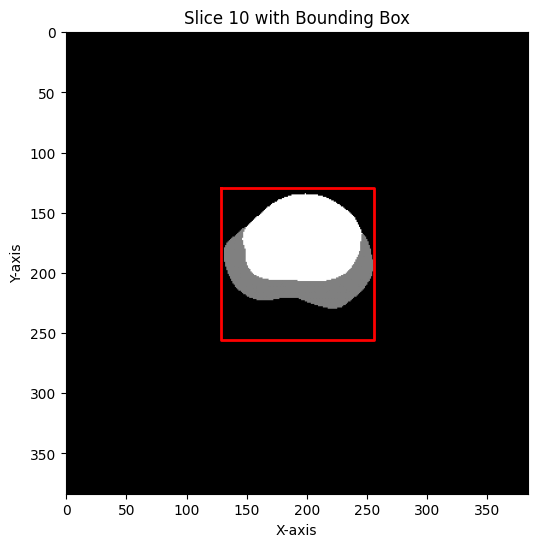

In [14]:
# pick a random number in the range of the dataframe and display the bounding box for the image

random_index = random.randint(0, len(df_box) - 1)
start_z, end_z, start_y, end_y, start_x, end_x, mask_path,\
    bounding_box_size, proportion_of_image_size = df_box.iloc[random_index]

mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask)

analyzer.overlay_bounding_box(mask_array, mask_array.shape[0] //2 ,start_y, end_y, start_x, end_x)

In [15]:
from ipywidgets import interact, IntSlider, fixed

# a slider to select the slice index
slider = IntSlider(value=mask_array.shape[0] // 2, min=0, max=mask_array.shape[0]-1, step=1, description='Slice Index')
# Use interact to create the interactive bounding box display
# Note: 'fixed' is used to pass fixed values for        
# the bounding box parameters so they don't change with the slider.
interact(analyzer.overlay_bounding_box, mask=fixed(mask_array), slice=slider, start_y=fixed(start_y), end_y=fixed(end_y), start_x=fixed(start_x), end_x=fixed(end_x))


interactive(children=(IntSlider(value=10, description='Slice Index', max=20), Output()), _dom_classes=('widget…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Now, we use the data from the dataframe to calculate a bounding box that is good for all the images.

The naive approach is to just find the max extent (biggest size between x and y) and add some padding to account for variability of the center location  and prostate size.

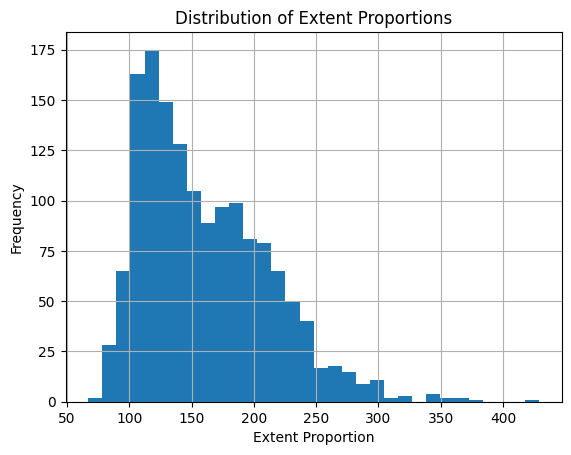

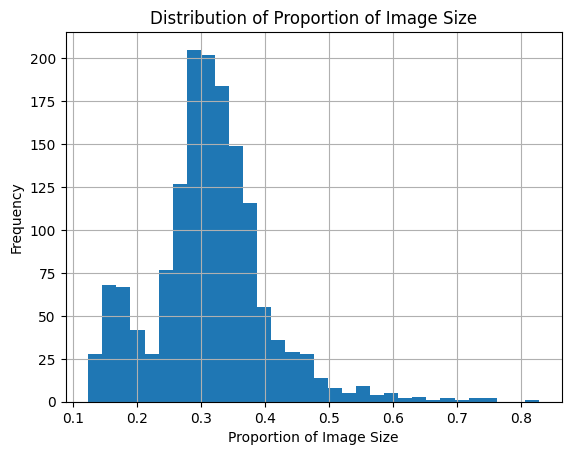

In [16]:
# using 'start_y', 'end_y', 'start_x', 'end_x', we calculate the 
# size of the bounding box as the maximum of the width and height, 
# and then calculate the proportion of that wrt the image size, to 
# get a sense of how much we can crop the image


# distribution of extent proportions
df_box['bounding_box_size'].hist(bins=32)
plt.title("Distribution of Extent Proportions")
plt.xlabel("Extent Proportion")
plt.ylabel("Frequency")
plt.show()

df_box['proportion_of_image_size'].hist(bins=32)
plt.title("Distribution of Proportion of Image Size")
plt.xlabel("Proportion of Image Size")
plt.ylabel("Frequency")
plt.show()



We see that most of the masks have proportional extents that lie below 0.5-0.60.
We can assume that a ROI that extends 0.6-0.7 off the center is fine for most cases

We don't want to go too low since we are also aiming to reduce computational costs.

As we see, some of the masks are exceptional in the sense that they have very large extents, so that might lead to some data loss.

In [17]:
# from the df, get the paths of the 5 images with the largest bounding box size and plot each with the bounding box
top5_bboxes = df_box.nlargest(5, 'proportion_of_image_size')
largest_bounding_box = top5_bboxes.iloc[0]
mask_path = largest_bounding_box['mask_path']
mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask)

print("Worst Mask Path:", top5_bboxes['mask_path'].iloc[0])
top5_bboxes[['mask_path', 'bounding_box_size', 'proportion_of_image_size']]

Worst Mask Path: /media/guest/PORT-DISK/Datasets/Prostate-Datasets/picai/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11475_1001499.nii.gz


,mask_path,bounding_box_size,proportion_of_image_size
1499,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,265,0.828125
497,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,289,0.752604
666,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,287,0.747396
746,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,279,0.726562
366,/media/guest/PORT-DISK/Datasets/Prostate-Datas...,231,0.721875


In [18]:


slider = IntSlider(value=mask_array.shape[0] // 2, min=0, max=mask_array.shape[0]-1, step=1, description='Slice Index')
interact(analyzer.overlay_bounding_box, mask=fixed(mask_array), slice=slider,
         start_y=fixed(largest_bounding_box['start_y']),
         end_y=fixed(largest_bounding_box['end_y']),
         start_x=fixed(largest_bounding_box['start_x']),
         end_x=fixed(largest_bounding_box['end_x']))


interactive(children=(IntSlider(value=9, description='Slice Index', max=18), Output()), _dom_classes=('widget-…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
largest_bounding_box = top5_bboxes.iloc[2]
mask_path = largest_bounding_box['mask_path']
mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask)

slider = IntSlider(value=mask_array.shape[0] // 2, min=0, max=mask_array.shape[0]-1, step=1, description='Slice Index')
interact(analyzer.overlay_bounding_box, mask=fixed(mask_array), slice=slider,
         start_y=fixed(largest_bounding_box['start_y']),
         end_y=fixed(largest_bounding_box['end_y']),
         start_x=fixed(largest_bounding_box['start_x']),
         end_x=fixed(largest_bounding_box['end_x']))

interactive(children=(IntSlider(value=9, description='Slice Index', max=18), Output()), _dom_classes=('widget-…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [21]:
from PIL import Image, ImageDraw

def create_gif_from_slices_with_bbox(mask_array, start_y, end_y, start_x, end_x, output_path="mask_slices_bbox.gif", duration=100, start=0, end=None):
    images = []
    if end is None:
        end = mask_array.shape[0]
    img_height, img_width = mask_array.shape[1], mask_array.shape[2]
    color_map = {
        0: (0, 0, 0),      # background
        1: (255, 255, 255),  # class 1 - white
        2: (128, 128, 128)   # class 2 - grey
    }
    for i in range(start, end):
        # Convert mask slice to RGB using color_map
        rgb_img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
        for label, color in color_map.items():
            rgb_img[mask_array[i] == label] = color
        img = Image.fromarray(rgb_img)
        draw = ImageDraw.Draw(img)
        # Draw bounding box
        draw.rectangle([start_x, start_y, end_x, end_y], outline="red", width=2)
        # put coordinates on the image
        draw.text((start_x + 5, start_y + 5), f"({start_x}, {start_y})", fill="red")
        draw.text((end_x - 50, end_y - 20), f"({end_x}, {end_y})", fill="red")
        # Append the image to the list  

        images.append(img)
    images[0].save(output_path, save_all=True, append_images=images[1:], duration=duration, loop=0)

for i in range(len(top5_bboxes)):

    largest_bounding_box = top5_bboxes.iloc[i]
    mask_path = largest_bounding_box['mask_path']
    mask = sitk.ReadImage(mask_path)
    mask_array = sitk.GetArrayFromImage(mask)

    start_y = largest_bounding_box['start_y']
    end_y = largest_bounding_box['end_y']
    start_x = largest_bounding_box['start_x']
    end_x = largest_bounding_box['end_x']

    create_gif_from_slices_with_bbox(mask_array, start_y, end_y, start_x, end_x, 
                                     output_path=f"mask_slices_bbox{i}.gif", duration=150)

In [22]:
# from the df, get the paths of the 5 images with the lowest proportion of image size and save to a gif

worst5_bboxes = df_box.nsmallest(5, 'proportion_of_image_size')

for i in range(len(worst5_bboxes)):
    largest_bounding_box = worst5_bboxes.iloc[i]
    mask_path = largest_bounding_box['mask_path']
    mask = sitk.ReadImage(mask_path)
    mask_array = sitk.GetArrayFromImage(mask)

    start_y = largest_bounding_box['start_y']
    end_y = largest_bounding_box['end_y']
    start_x = largest_bounding_box['start_x']
    end_x = largest_bounding_box['end_x']

    create_gif_from_slices_with_bbox(mask_array, start_y, end_y, start_x, end_x, 
                                     output_path=f"worst_mask_slices_bbox{i}.gif", duration=150)



In [25]:
# sort the dataset by proportion of image size and pick some images around 0.3

# get the index of the first image with proportion of image size > 0.3
index = df_box[df_box['proportion_of_image_size'] > 0.3].index[0]
# get the images around that index
start_index = max(0, index - 2)
end_index = min(len(df_box), index + 3)

# save them to a gif
for i in range(start_index, end_index):
    largest_bounding_box = df_box.iloc[i]
    mask_path = largest_bounding_box['mask_path']
    mask = sitk.ReadImage(mask_path)
    mask_array = sitk.GetArrayFromImage(mask)

    start_y = largest_bounding_box['start_y']
    end_y = largest_bounding_box['end_y']
    start_x = largest_bounding_box['start_x']
    end_x = largest_bounding_box['end_x']

    create_gif_from_slices_with_bbox(mask_array, start_y, end_y, start_x, end_x, 
                                     output_path=f"around_0.3_mask_slices_bbox{i}.gif", duration=150)
